In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import torch
from torch import nn
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms, datasets, models
from torchvision.models import resnet50, densenet121, inception_v3
from torchsummary import summary
from collections import OrderedDict
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import wandb
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

In [2]:
BATCH_SIZE = 4

In [3]:
class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=False):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.train = train
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        
        self.augment_classes = ['None', 'Many']
        self.augment_indices = [self.class_to_idx[cls] for cls in self.augment_classes if cls in self.class_to_idx]
        
        # Count samples per class
        self.class_counts = [0] * len(self.classes)
        for _, label in self.dataset.samples:
            self.class_counts[label] += 1
        
        # Calculate class weights once
        total_samples = sum(self.class_counts)
        self.class_weights = [total_samples / (len(self.class_counts) * count) for count in self.class_counts]
        
        if self.train:
            self.train_augs = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Reduced limits
                A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),  # Reduced upper var_limit
                A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.1, rotate_limit=10, p=0.5),])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        if self.train and label in self.augment_indices:
            img_np = np.array(img)
            augmented = self.train_augs(image=img_np)
            img_np = augmented['image']
            img = Image.fromarray(img_np)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def get_sample_weights(self):
        return [self.class_weights[label] for _, label in self.dataset.samples]

In [4]:
def create_weighted_sampler(dataset, indices):
    sample_weights = dataset.get_sample_weights()
    subset_weights = [sample_weights[i] for i in indices]
    return WeightedRandomSampler(subset_weights, len(subset_weights), replacement=True)

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create full datasets
full_dataset = AugmentedDataset('data', transform=transform)
print(len(full_dataset))
print(full_dataset.class_counts)
print(sum(full_dataset.class_counts))
dummy_loader = DataLoader(full_dataset, batch_size=1, shuffle=True)

8724
[6232, 256, 2236]
8724


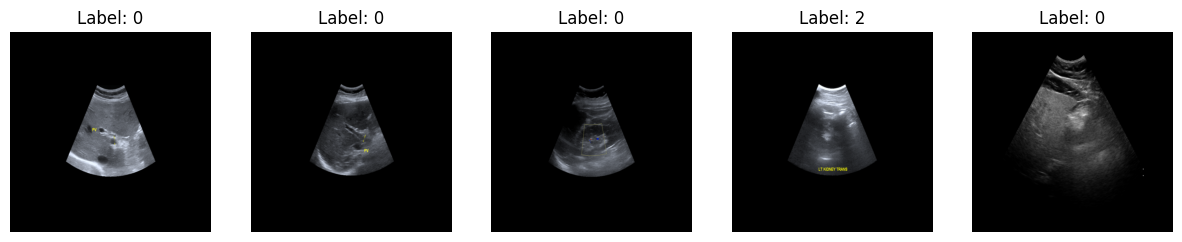

In [5]:
# Function to get images of a specific label
def get_images_by_label(dataloader, num_images=1, label=None):
    images = []
    labels = []
    if label is None:
        # Get random images not considering the label
        for batch_images, batch_labels in dataloader:
            for img, lbl in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    for batch_images, batch_labels in dataloader:
        for img, lbl in zip(batch_images, batch_labels):
            if lbl == label:
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    return images, labels

# Example usage: Get 5 images of label 0
label_to_display = 2
num_images_to_display = 5
images, labels = get_images_by_label(dummy_loader, num_images_to_display, label=None)

# Display the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images, labels)):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f'Label: {lbl}')
    axes[i].axis('off')
plt.show()

In [6]:
num_class = len(dummy_loader.dataset.classes)
print(num_class)
print(dummy_loader.dataset.classes)

3
['Few', 'Many', 'None']


In [7]:
class_weights = torch.tensor(full_dataset.class_weights, dtype=torch.float)
print(class_weights)
print(full_dataset.classes)

tensor([ 0.4666, 11.3594,  1.3005])
['Few', 'Many', 'None']


In [8]:
for batch in dummy_loader:
    print(batch)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), tensor([0])]


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score


def calculate_metrics(y_true, y_pred, y_prob, train=False):

    if train:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return auc, f1
    
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class
    metrics = []
    sensitivities = []
    specificities = []
    
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - TP - FP - FN
        
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        
        metrics.append({
            'sensitivity': sensitivity,
            'specificity': specificity
        })
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate ROC-AUC and F1 score for validation set
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Calculate averaged sensitivity and specificity
    avg_sensitivity = sum(sensitivities) / len(sensitivities) if sensitivities else 0
    avg_specificity = sum(specificities) / len(specificities) if specificities else 0
    
    return accuracy, metrics, auc, f1, cm, avg_sensitivity, avg_specificity

def plot_confusion_matrix(cm, class_names, epoch_num=0, model_name='model', fold_num=0):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'figures/confusion_matrix_{model_name}_epoch_{epoch_num}_fold{fold_num}.png')
    plt.close()

def custom_log(metrics, model_name, log_dir='logs'):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    log_file = f'{log_dir}/{model_name}_metrics_log.json'
    with open(log_file, 'a') as f:
        f.write(json.dumps(metrics) + '\n')

In [10]:
class Classifier(nn.Module):
    def __init__(self, num_class, in_features=2048):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(in_features, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        #x = torch.softmax(x, dim=-1)
        return x

class InceptionBackbone(nn.Module):
    def __init__(self, path, num_classes):
        super().__init__()
        base_model = inception_v3(weights=None, aux_logits=False)
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:-1])
        
        state_dict = torch.load(path)
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[k[9:]] = v

        print(self.backbone.load_state_dict(new_state_dict))  # <All keys matched successfully>
        
        self.classifier = Classifier(num_classes)
                        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import wandb

def train_model(model, criterion, optimizer, train_loader, val_loader, class_names, num_epochs=30, device='cuda', model_name='model', fold=0):
    wandb.init(project="Hepatocyte Ballooning Detection", name=f"RadImageNet {model_name} Fold {fold+1}")
    wandb.watch(model, criterion, log='all')

    print(f'Training {model_name} for {num_epochs} epochs on Fold {fold+1}')
    max_f1 = 0
    best_metrics = {}
    
    for e in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels, train_probs = [], [], []


        for i_batch, batch in enumerate(train_loader):
            data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)  # Get probabilities

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())  # Store probabilities

        # Calculate metrics
        train_auc, train_f1 = calculate_metrics(train_labels, train_preds, train_probs, train=True)


        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels, val_probs = [], [], []

        with torch.no_grad():
            for i_batch, batch in enumerate(val_loader):
                data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
                
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * data.size(0)

                probs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        # Calculate metrics
        val_accuracy, val_class_metrics, val_auc, val_f1, val_cm, avg_sensitivity, avg_specificity = calculate_metrics(val_labels, val_preds, val_probs)

        print(f'Epoch {e+1}')
        val_loss /= len(val_loader.dataset)
        train_loss /= len(train_loader.dataset)
        print(f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation AUC: {val_auc:.4f}')
        print(f'Macro-averaged F1 Score: {val_f1:.4f}')
        print(f'Averaged Sensitivity: {avg_sensitivity:.4f}, Averaged Specificity: {avg_specificity:.4f}')
        for i, metrics in enumerate(val_class_metrics):
            print(f'Class {class_names[i]} - Sensitivity: {metrics["sensitivity"]:.4f}, Specificity: {metrics["specificity"]:.4f}')

        # Log metrics to wandb and custom logger
        metrics = {
            'fold': fold + 1,
            'epoch': e + 1,
            'train_loss': train_loss,
            'train_auc': train_auc,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_auc': val_auc,
            'val_f1': val_f1,
            'avg_sensitivity': avg_sensitivity,
            'avg_specificity': avg_specificity,
            **{f'class_{class_names[i]}_sensitivity': metrics["sensitivity"] for i, metrics in enumerate(val_class_metrics)},
            **{f'class_{class_names[i]}_specificity': metrics["specificity"] for i, metrics in enumerate(val_class_metrics)},
            **{f'class_{class_names[i]}_f1': 2 * metrics["sensitivity"] * metrics["specificity"] / (metrics["sensitivity"] + metrics["specificity"]) for i, metrics in enumerate(val_class_metrics)}
        }

        # Log to wandb
        wandb.log(metrics)

        # Log to custom logger
        custom_log(metrics, model_name)

        # Save the last model and delete one before it to chekpoint directory
        torch.save(model.state_dict(), f'checkpoints/last_{model_name}_epoch_{e+1}_fold_{fold+1}.pth')
        if e > 0:
            os.remove(f'checkpoints/last_{model_name}_epoch_{e}_fold_{fold+1}.pth')
        
        # Save the best model
        if max_f1 < val_f1:
            print(f'Macro F1 Increased({max_f1:.6f}--->{val_f1:.6f}) \t Saving The Model')
            max_f1 = val_f1
            best_metrics = deepcopy(metrics)
            torch.save(model.state_dict(), f'checkpoints/best/best_{model_name}_epoch_{e+1}_fold_{fold+1}.pth')
            
            # Plot confusion matrix for the best model
            plot_confusion_matrix(val_cm, class_names, e+1, model_name, fold+1)

    return model, best_metrics

In [12]:
models = os.listdir('models')
print(models)
model_name = models[2] # InceptionV3

['ResNet50.pt', 'DenseNet121.pt', 'InceptionV3.pt']


In [13]:
# Define the path to the data
data_path = 'data'

# List the folders in the data path
folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Initialize a dictionary to store the count of images in each folder
image_counts = {}

# Iterate through each folder and count the number of image files
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    image_counts[folder] = len(image_files)

# Display the results
for folder, count in image_counts.items():
    print(f'Folder: {folder}, Number of images: {count}')

Folder: None, Number of images: 2236
Folder: Few, Number of images: 6232
Folder: Many, Number of images: 256


In [14]:
# Make all the needed directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('checkpoints/best', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('logs/best', exist_ok=True)
os.makedirs('figures', exist_ok=True)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_metrics_lst = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# start from 2nd fold
for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset, full_dataset.dataset.targets)):
	if fold < 1:
		continue
	print(f"Fold {fold + 1}")
	
	# Create training and validation subsets
	train_subset = Subset(full_dataset, train_idx)
	val_subset = Subset(full_dataset, val_idx)
	
	sampler = create_weighted_sampler(full_dataset, train_idx)

	# Create DataLoaders
	train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler)
	val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

	# Load the model
	model_path = f'models/{model_name}'
	model = InceptionBackbone(model_path, num_class).to(device)

	# Define loss function and optimizer
	criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
	optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

	# Train the model
	model, best_metrics = train_model(model, criterion, optimizer, train_loader, val_loader, full_dataset.dataset.classes, num_epochs=30, device=device, model_name=model_name, fold=fold)
	best_metrics_lst.append(best_metrics)
	custom_log(best_metrics, model_name + '_best', log_dir='logs/best')
	print(f"Best Validation Metrics of Fold {fold+1}:")
	print(f"Accuracy: {best_metrics['val_accuracy']:.4f}")
	print(f"AUC: {best_metrics['val_auc']:.4f}")
	print(f'Macro-averaged F1 Score: {best_metrics["val_f1"]:.4f}')
	print(f'Averaged Sensitivity: {best_metrics["avg_sensitivity"]:.4f}, Averaged Specificity: {best_metrics["avg_specificity"]:.4f}')
	
	wandb.finish()

Fold 2


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samwellwatwat. Use `wandb login --relogin` to force relogin


Training InceptionV3.pt for 30 epochs on Fold 2
Epoch 1
Training Loss: 0.1400, Validation Loss: 1.4458
Validation Accuracy: 0.4147
Validation AUC: 0.7085
Macro-averaged F1 Score: 0.4205
Averaged Sensitivity: 0.6087, Averaged Specificity: 0.7236
Class Few - Sensitivity: 0.2804, Specificity: 0.8715
Class Many - Sensitivity: 0.8000, Specificity: 0.8785
Class None - Sensitivity: 0.7455, Specificity: 0.4206
Macro F1 Increased(0.000000--->0.420523) 	 Saving The Model
Epoch 2
Training Loss: 0.0899, Validation Loss: 0.9449
Validation Accuracy: 0.5166
Validation AUC: 0.7334
Macro-averaged F1 Score: 0.5408
Averaged Sensitivity: 0.6377, Averaged Specificity: 0.7533
Class Few - Sensitivity: 0.4343, Specificity: 0.8112
Class Many - Sensitivity: 0.7600, Specificity: 0.9139
Class None - Sensitivity: 0.7188, Specificity: 0.5347
Macro F1 Increased(0.420523--->0.540826) 	 Saving The Model
Epoch 3
Training Loss: 0.0669, Validation Loss: 1.1319
Validation Accuracy: 0.4754
Validation AUC: 0.7512
Macro-aver

avg_sensitivity,▂▃▃▁▁▂▆▂▂▅▆▆▃▇▄▄▄▃▅▇▅▆▅▆▇█▆▆▆▆
avg_specificity,▂▃▃▁▁▄▆▄▃▅▆▅▃▇▆▅▆▅▆▆▇▇▆▇██▆█▇▇
class_Few_f1,▃▅▄▂▁▅▇▆▄▆▇▆▄▇▇▆▇▇▇▇▇▇▇███▇███
class_Few_sensitivity,▂▄▃▂▁▄█▄▃▄▆▅▃▆▅▄▅▇▅▆▇▇▆▇██▆▇▇▇
class_Few_specificity,▆▅▆▇█▆▂▆▇▇▅▆█▆▆▇▆▁▇▅▃▄▆▅▄▄▅▆▅▄
class_Many_f1,▆▆▆▆▅▃▆▂▃▅▇▇▅▇▁▃▃▃▃█▂▅▄▃▄▇▅▃▄▃
class_Many_sensitivity,▅▅▅█▃▂▄▂▂▃▅▅▃▅▁▂▂▂▂▆▂▃▃▂▃▅▃▂▃▂
class_Many_specificity,▅▆▅▁▇▇███▇▇█████▇▇█▅███▇██▇███
class_None_f1,▄▅▅▄▁▅▇▅▄▆▇▆▄▇▇▅▇▆▇▇▇█▇███▇███
class_None_sensitivity,▄▄▅▁▇▅▂▆▇▇▄▆█▆▇▇▆▁▇▄▄▅▆▅▄▅▅▆▅▅
class_None_specificity,▃▄▄▄▁▄█▄▃▅▆▅▂▆▅▄▆▇▅▇▇▇▆▇██▇▇▇▇


Fold 3


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


Training InceptionV3.pt for 30 epochs on Fold 3
Epoch 1
Training Loss: 0.1405, Validation Loss: 1.1093
Validation Accuracy: 0.2738
Validation AUC: 0.7711
Macro-averaged F1 Score: 0.1444
Averaged Sensitivity: 0.5482, Averaged Specificity: 0.6823
Class Few - Sensitivity: 0.0193, Specificity: 0.9920
Class Many - Sensitivity: 0.6923, Specificity: 0.9055
Class None - Sensitivity: 0.9330, Specificity: 0.1495
Macro F1 Increased(0.000000--->0.144420) 	 Saving The Model
Epoch 2
Training Loss: 0.0898, Validation Loss: 1.3950
Validation Accuracy: 0.2910
Validation AUC: 0.8085
Macro-averaged F1 Score: 0.1607
Averaged Sensitivity: 0.6338, Averaged Specificity: 0.6910
Class Few - Sensitivity: 0.0273, Specificity: 1.0000
Class Many - Sensitivity: 0.9231, Specificity: 0.9126
Class None - Sensitivity: 0.9509, Specificity: 0.1602
Macro F1 Increased(0.144420--->0.160750) 	 Saving The Model
Epoch 3
Training Loss: 0.0667, Validation Loss: 0.9418
Validation Accuracy: 0.6105
Validation AUC: 0.7850
Macro-aver

avg_sensitivity,▁▃▆▄▂▆▆▅▅▅▇▆▇▆▆▆▆▇▇▇▇▆▇▇▇▇▆▇█▇
avg_specificity,▁▁▅▃▃▆▆▅▄▅▆▆▇▆▆▆▅█▇██▇█▇█▇▆▆█▇
class_Few_f1,▁▁▆▄▄▇▇▇▆▆▇▇█▇▇▇▆█████████▇▇██
class_Few_sensitivity,▁▁▅▃▃▅▆▆▄▅▆▆▇▅█▆▄▇▆█▇▆▇▇▇▆▆▆█▆
class_Few_specificity,██▅█▇▅▅▄▆▅▆▅▄▆▁▅▇▅▆▄▆▆▅▅▆▆▅▆▄▆
class_Many_f1,▁▆▇▇▂▇▆▃▇▃█▇▇▅▅▆▆▃▅▆▅▂▄▅▅▄▆▆▇▅
class_Many_sensitivity,▁▆▇▆▂▆▆▂▆▇█▅▅▄▄▅▅▂▄▅▄▁▃▄▄▃▅▅▅▄
class_Many_specificity,▅▆▆▆▆▇▅█▇▁▆████████▇███▇██▆███
class_None_f1,▁▁▆▄▄▇▇▇▅▇▇▇▇▆▆▇▆█████████▇▇██
class_None_sensitivity,██▅▇▅▆▄▅▆▃▆▅▅▇▁▆█▆▇▄▆▆▅▆▆▇▅▇▅▇
class_None_specificity,▁▁▅▂▃▅▇▆▄▇▆▆▇▅█▆▄▇▆█▇▆▇▇▇▆▆▅█▆


Fold 4


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


Training InceptionV3.pt for 30 epochs on Fold 4
Epoch 1
Training Loss: 0.1368, Validation Loss: 0.9915
Validation Accuracy: 0.4433
Validation AUC: 0.7394
Macro-averaged F1 Score: 0.4509
Averaged Sensitivity: 0.6054, Averaged Specificity: 0.7316
Class Few - Sensitivity: 0.3130, Specificity: 0.8640
Class Many - Sensitivity: 0.7308, Specificity: 0.9103
Class None - Sensitivity: 0.7723, Specificity: 0.4206
Macro F1 Increased(0.000000--->0.450865) 	 Saving The Model
Epoch 2
Training Loss: 0.0836, Validation Loss: 0.8858
Validation Accuracy: 0.3574
Validation AUC: 0.8128
Macro-averaged F1 Score: 0.2899
Averaged Sensitivity: 0.6043, Averaged Specificity: 0.7082
Class Few - Sensitivity: 0.1268, Specificity: 0.9720
Class Many - Sensitivity: 0.7308, Specificity: 0.9799
Class None - Sensitivity: 0.9554, Specificity: 0.1726
Epoch 3
Training Loss: 0.0628, Validation Loss: 0.9218
Validation Accuracy: 0.5601
Validation AUC: 0.7951
Macro-averaged F1 Score: 0.5899
Averaged Sensitivity: 0.6855, Averaged

avg_sensitivity,▁▁▄▃▃▅▁▅▅▄▃▄▇▄▆▅▇▇▆▆▄██▇▇▇▅▇▆▇
avg_specificity,▂▁▄▂▃▅▃▆▆▅▄▄▆▆▆▅█▇▇▇▄██▇█▇▇▇▇▇
class_Few_f1,▄▁▅▃▄▇▄▇▇▆▅▅▇▇▇▆██▇▇▆██▇█▇▇█▇█
class_Few_sensitivity,▃▁▄▂▃▅▃▆▅▄▄▃▆▇▅▄█▇█▆▄▆▇▆██▆▇▆▇
class_Few_specificity,▅█▆▇▅▅▆▅▆▇██▆▂▆▇▃▃▁▅▇▇▆▅▃▁▆▄▆▅
class_Many_f1,▄▅▅█▆▅▁▃▂▄▂▄▆▁▅▄▃▅▃▄▄▅▅▇▄▅▃▄▃▃
class_Many_sensitivity,▅▅▆█▅▅▁▃▂▄▂▄▅▁▅▄▃▅▃▄▄▅▅▆▄▅▃▄▃▃
class_Many_specificity,▃▇▁▄▆█▇██▆██▇█▇██▇██▇█▇▅█▇▄▇██
class_None_f1,▄▁▆▃▄▆▄▇▇▆▅▄▇▇▇▆█▇▇▇▅██▇█▇▇█▇█
class_None_sensitivity,▃▇▃▆▅▅▆▅▆▇▇█▆▂▇▇▃▃▁▆▇▇▆▄▄▁▄▄▆▅
class_None_specificity,▃▁▅▂▃▅▃▆▅▄▃▃▆▇▅▄█▇█▆▄▆▇▇██▇▇▆▇


Fold 5


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


Training InceptionV3.pt for 30 epochs on Fold 5
Epoch 1
Training Loss: 0.1441, Validation Loss: 1.4067
Validation Accuracy: 0.2362
Validation AUC: 0.7132
Macro-averaged F1 Score: 0.1074
Averaged Sensitivity: 0.5231, Averaged Specificity: 0.6731
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.7308, Specificity: 0.8499
Class None - Sensitivity: 0.8386, Specificity: 0.1695
Macro F1 Increased(0.000000--->0.107372) 	 Saving The Model
Epoch 2
Training Loss: 0.0971, Validation Loss: 1.0796
Validation Accuracy: 0.5000
Validation AUC: 0.7416
Macro-averaged F1 Score: 0.5206
Averaged Sensitivity: 0.6260, Averaged Specificity: 0.7496
Class Few - Sensitivity: 0.4029, Specificity: 0.8273
Class Many - Sensitivity: 0.7308, Specificity: 0.9113
Class None - Sensitivity: 0.7444, Specificity: 0.5100
Macro F1 Increased(0.107372--->0.520648) 	 Saving The Model
Epoch 3
Training Loss: 0.0692, Validation Loss: 1.5824
Validation Accuracy: 0.3154
Validation AUC: 0.7305
Macro-aver

avg_sensitivity,▂▄▁▄▄▆▄▅▇▇▇▇▆▆▆█▅▇▇▇▇██▇█▇▇▇█▇
avg_specificity,▁▃▂▂▃▅▂▃▆▆▅▆▅▇▇▇▅▇▅▆▆█▇▆▇▇▇▇█▇
class_Few_f1,▁▅▂▃▄▇▃▄▇▇▇▇▆▇▇█▇█▇▇▇█▇▇▇████▇
class_Few_sensitivity,▁▄▂▂▃▆▂▃▆▆▅▇▅▇▆▇▅▇▅▆▆█▆▇▆▇█▆█▆
class_Few_specificity,█▃██▇▂█▆▄▄▅▂▆▄▄▃▆▃▅▄▆▃▅▃▅▃▁▆▂▆
class_Many_f1,▆▆▁▇▇▇▇██▇██▇▆▅█▅██▇▇▇███▇▇▇▇▆
class_Many_sensitivity,▆▆▁▇▇▇▇██▇█▇▆▅▄█▄▇▇█▇▆▇▇█▇▆▆▆▆
class_Many_specificity,▁▄█▄▄▅▇▅▇█▇▇███▆█▇▇▄███▇▇▆▇▇██
class_None_f1,▂▆▁▃▄▇▂▅▇▇▇▇▆▇▇█▆▇▆▇▇█▇▇█████▇
class_None_sensitivity,▅▂█▇▆▁█▆▄▄▅▃▆▄▅▂▇▃▅▁▆▃▆▃▆▃▁▆▃▆
class_None_specificity,▂▅▁▂▃▆▂▃▆▆▅▇▄▆▆▇▅▇▅▇▅█▆▇▆▇█▆█▆


Fold 6


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


Training InceptionV3.pt for 30 epochs on Fold 6
Epoch 1
Training Loss: 0.1426, Validation Loss: 0.8391
Validation Accuracy: 0.5344
Validation AUC: 0.7414
Macro-averaged F1 Score: 0.5544
Averaged Sensitivity: 0.6931, Averaged Specificity: 0.7634
Class Few - Sensitivity: 0.4414, Specificity: 0.8233
Class Many - Sensitivity: 0.8846, Specificity: 0.9184
Class None - Sensitivity: 0.7534, Specificity: 0.5485
Macro F1 Increased(0.000000--->0.554389) 	 Saving The Model
Epoch 2
Training Loss: 0.0834, Validation Loss: 0.7726
Validation Accuracy: 0.6571
Validation AUC: 0.7739
Macro-averaged F1 Score: 0.6764
Averaged Sensitivity: 0.6955, Averaged Specificity: 0.8018
Class Few - Sensitivity: 0.6292, Specificity: 0.7711
Class Many - Sensitivity: 0.7308, Specificity: 0.9764
Class None - Sensitivity: 0.7265, Specificity: 0.6579
Macro F1 Increased(0.554389--->0.676443) 	 Saving The Model
Epoch 3
Training Loss: 0.0658, Validation Loss: 0.7107
Validation Accuracy: 0.6227
Validation AUC: 0.7685
Macro-aver

avg_sensitivity,▃▃▁▃▄▄▄▆▅▅▆▄▆▄▅▅▅▇▅▅▆▇▆█▆▆▆▆▇▆
avg_specificity,▁▃▂▄▃▄▅▅▆▆▇▅▄▄▆▇▅▇▅█▇▇▆██▇▆█▇▇
class_Few_f1,▁▄▃▄▄▅▅▅▆▇▇▅▄▅▇▇▅█▅███▇███▇█▇▇
class_Few_sensitivity,▁▄▃▄▄▄██▆██▄▃▆▇▇▄▇▄▇█▆▇▇█▇▅█▅▆
class_Few_specificity,▆▅▅▆▅▅▁▂▅▄▄▇█▄▄▆█▆▇▆▅▇▅▇▅▆█▅▇▇
class_Many_f1,█▅▁▃▇▆▄█▄▃▄▅█▆▃▁▄▅▄▁▃▆▆▇▄▃▅▂▇▅
class_Many_sensitivity,█▅▁▃▆▆▄▇▄▃▄▄▇▆▃▁▄▅▄▁▃▅▅▆▄▃▅▂▆▅
class_Many_specificity,▂▇▆▇▅▁▇▇▇▇██▇▂▇█▇███▇▇▇▇█▇▆█▇▇
class_None_f1,▁▃▂▃▃▄▃▄▆▆▆▄▃▂▆▇▅▇▅█▇▇▆█▇▇▆▇▆▇
class_None_sensitivity,▅▄▄▆▄▄▁▂▅▄▄▇█▁▄▆█▇▇▇▅▇▅▇▅▆▇▆▇▇
class_None_specificity,▁▃▂▃▃▅██▅██▃▂▆▇▆▃▆▃▇▇▆▆▇▇▇▄▇▅▆


Fold 7


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


Training InceptionV3.pt for 30 epochs on Fold 7
Epoch 1
Training Loss: 0.1385, Validation Loss: 1.1747
Validation Accuracy: 0.4094
Validation AUC: 0.6519
Macro-averaged F1 Score: 0.4606
Averaged Sensitivity: 0.5717, Averaged Specificity: 0.7253
Class Few - Sensitivity: 0.3531, Specificity: 0.8153
Class Many - Sensitivity: 0.8462, Specificity: 0.7258
Class None - Sensitivity: 0.5157, Specificity: 0.6348
Macro F1 Increased(0.000000--->0.460587) 	 Saving The Model
Epoch 2
Training Loss: 0.0863, Validation Loss: 1.0464
Validation Accuracy: 0.3417
Validation AUC: 0.7693
Macro-averaged F1 Score: 0.2688
Averaged Sensitivity: 0.6614, Averaged Specificity: 0.7123
Class Few - Sensitivity: 0.1124, Specificity: 0.9799
Class Many - Sensitivity: 0.9615, Specificity: 0.8889
Class None - Sensitivity: 0.9103, Specificity: 0.2681
Epoch 3
Training Loss: 0.0623, Validation Loss: 0.9009
Validation Accuracy: 0.4656
Validation AUC: 0.8126
Macro-averaged F1 Score: 0.4557
Averaged Sensitivity: 0.6389, Averaged

avg_sensitivity,▁▄▃▅▄▄▅▃▇▆▆▇▅▆▆▅▆▇▇▇▇█▇█▅██▇▇▆
avg_specificity,▁▁▂▆▃▅▄▃▆▅▅▆▄▆▆▄▆▇▇▇▇███▆██▇▇▇
class_Few_f1,▄▁▄▇▄▇▆▆▇▆▆▇▅▇▇▅▇█▇█▇███▇████▇
class_Few_sensitivity,▃▁▂▇▃▆▄▅▇▅▄▆▄▆▅▄▆▇█▇█▇▇█▆▇▇█▇▆
class_Few_specificity,▄█▇▁▇▃▇▁▁▆▇▄▇▅▆▇▅▃▁▄▁▆▇▃▆▄▅▂▄▆
class_Many_f1,▄█▅▄▆▅▇▅▇▆█▇▅▅▆▅▅▇▇▅▇▆▅▇▁▆▇▅▆▄
class_Many_sensitivity,▆█▄▃▅▄▅▄▅▅▇▆▄▄▅▄▄▅▅▄▅▅▄▅▁▅▅▄▅▄
class_Many_specificity,▁▅███▆▇▇██▇▇█████▇███▇████▇██▇
class_None_f1,▄▁▂▆▃▆▅▄▆▆▅▆▄▇▇▄▇▇▇▇▆███▇██▇▇▇
class_None_sensitivity,▁██▃▇▄▇▂▃▇▇▅█▆▇█▆▅▃▆▃▇▇▅▇▅▆▅▅▆
class_None_specificity,▅▁▂▇▂▆▄▅▇▅▄▆▃▆▅▃▆▇█▇█▇▆█▅▇▇█▇▆


Fold 8


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


Training InceptionV3.pt for 30 epochs on Fold 8
Epoch 1
Training Loss: 0.1375, Validation Loss: 1.1663
Validation Accuracy: 0.3005
Validation AUC: 0.7143
Macro-averaged F1 Score: 0.2107
Averaged Sensitivity: 0.6439, Averaged Specificity: 0.6974
Class Few - Sensitivity: 0.0706, Specificity: 0.9920
Class Many - Sensitivity: 1.0000, Specificity: 0.8783
Class None - Sensitivity: 0.8610, Specificity: 0.2219
Macro F1 Increased(0.000000--->0.210722) 	 Saving The Model
Epoch 2
Training Loss: 0.0863, Validation Loss: 1.2425
Validation Accuracy: 0.2821
Validation AUC: 0.7232
Macro-averaged F1 Score: 0.1631
Averaged Sensitivity: 0.5174, Averaged Specificity: 0.6792
Class Few - Sensitivity: 0.0337, Specificity: 0.9759
Class Many - Sensitivity: 0.5769, Specificity: 0.9444
Class None - Sensitivity: 0.9417, Specificity: 0.1171
Epoch 3
Training Loss: 0.0632, Validation Loss: 1.1895
Validation Accuracy: 0.3589
Validation AUC: 0.7589
Macro-averaged F1 Score: 0.2953
Averaged Sensitivity: 0.6374, Averaged

avg_sensitivity,▄▁▄▅▆▆▇▇▄▆█▆▆▆▅▇▆▇█▇█▇█▇▇█▇███
avg_specificity,▂▁▂▄▃▅▅▆▅▅▆▆▅▆▆▆▆▆▇▇▇▆▇▇▇▇▇█▇█
class_Few_f1,▂▁▂▅▅▆▇▇▇▆▇▇▇▇▇▇▇▆█▇▇▇█▇▇▇████
class_Few_sensitivity,▁▁▂▄▃▆▅▇▇█▆▆▅▇▆▆█▅▇▆▆▆▇██▇▇▇██
class_Few_specificity,███▆▇▄▆▄▄▁▆▆▆▅▅▆▂▇▆▇▆▆▅▄▄▅▅▅▅▆
class_Many_f1,█▂▇▆█▇▇▇▁▆▇▅▆▄▂▆▄▆▆▅▆▄▅▄▅▆▃▅▅▄
class_Many_sensitivity,█▂▆▆▇▅▅▅▁▅▆▄▅▃▂▅▃▅▅▄▅▃▄▃▄▅▃▄▄▃
class_Many_specificity,▁▅▆▂▄▇█▆████▇▇█▇█▅█▇▇██████▇██
class_None_f1,▃▁▂▅▅▆▆▇▆▆▇▇▇▇▇▇▆▇▇▇▇▇█▇▇▇██▇█
class_None_sensitivity,▇██▆▆▅▇▄▄▁▆▇▆▅▆▆▂█▆▇▇▇▆▅▅▅▆▆▅▆
class_None_specificity,▂▁▂▄▄▆▅▇▆█▆▆▅▇▆▆█▅▇▆▆▆▇█▇▇▇███


Fold 9


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


Training InceptionV3.pt for 30 epochs on Fold 9
Epoch 1
Training Loss: 0.1447, Validation Loss: 1.5303
Validation Accuracy: 0.2569
Validation AUC: 0.6806
Macro-averaged F1 Score: 0.1717
Averaged Sensitivity: 0.6028, Averaged Specificity: 0.6886
Class Few - Sensitivity: 0.0449, Specificity: 0.9880
Class Many - Sensitivity: 1.0000, Specificity: 0.7615
Class None - Sensitivity: 0.7634, Specificity: 0.3164
Macro F1 Increased(0.000000--->0.171701) 	 Saving The Model
Epoch 2
Training Loss: 0.0948, Validation Loss: 2.3114
Validation Accuracy: 0.2385
Validation AUC: 0.6952
Macro-averaged F1 Score: 0.1402
Averaged Sensitivity: 0.5568, Averaged Specificity: 0.6837
Class Few - Sensitivity: 0.0225, Specificity: 1.0000
Class Many - Sensitivity: 0.8800, Specificity: 0.7532
Class None - Sensitivity: 0.7679, Specificity: 0.2978
Epoch 3
Training Loss: 0.0774, Validation Loss: 1.1194
Validation Accuracy: 0.3945
Validation AUC: 0.7842
Macro-averaged F1 Score: 0.3649
Averaged Sensitivity: 0.6396, Averaged

avg_sensitivity,▂▁▃▄▃▃▅▆▄▅▆▅▆▅▅▇▇▆▇▇▆█▇▇▆▇▇▆▇▆
avg_specificity,▁▁▂▃▃▂▄▅▄▄▆▆▆▅▆▇▇▇▇▇▇▇██▇█▇▇▇▆
class_Few_f1,▁▁▄▅▅▄▆▆▆▆▇▇▇▇▇▇█▇█▇█████████▇
class_Few_sensitivity,▁▁▂▄▄▃▄▅▅▅█▅▇▅▆▇▇▆█▇▇▇▇▇▇▇▇▇█▆
class_Few_specificity,██▇▆▆▇▆▅▆▄▁▆▃▆▆▄▅▆▄▅▅▄▆▅▄▅▄▄▃▇
class_Many_f1,▆▄▆▆▅▅▇▇▅▇▅▃▇▅▁▆▄▄▅▆▂█▄▃▃▅▆▄▅▅
class_Many_sensitivity,█▆▅▆▄▄▅▇▅▅▄▂▅▄▁▅▃▃▄▅▂▇▃▂▂▄▅▃▄▄
class_Many_specificity,▁▁▆▄▇▇▇▅▃█▇▇▇▆█▇▇██▇█▇████▆███
class_None_f1,▁▁▁▄▃▁▄▅▅▅▆▆▆▆▆▇█▇▇▇▇▇██▇█▆▇▇▆
class_None_sensitivity,▅▅▇▅▇█▇▅▄▅▁▇▂▆█▅▆▇▅▆▆▅▇▇▆▇▃▅▄█
class_None_specificity,▁▁▁▄▂▁▃▅▅▅█▅▇▅▅▇▇▆▇▇▇▇▇▇▇▇█▇█▅


Fold 10


/home/samo/dev/liver/.venv/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>


Training InceptionV3.pt for 30 epochs on Fold 10
Epoch 1
Training Loss: 0.1457, Validation Loss: 1.4310
Validation Accuracy: 0.4667
Validation AUC: 0.6444
Macro-averaged F1 Score: 0.5219
Averaged Sensitivity: 0.6336, Averaged Specificity: 0.7392
Class Few - Sensitivity: 0.4318, Specificity: 0.7631
Class Many - Sensitivity: 0.9600, Specificity: 0.7355
Class None - Sensitivity: 0.5089, Specificity: 0.7191
Macro F1 Increased(0.000000--->0.521852) 	 Saving The Model
Epoch 2
Training Loss: 0.0962, Validation Loss: 1.3686
Validation Accuracy: 0.2844
Validation AUC: 0.6865
Macro-averaged F1 Score: 0.2368
Averaged Sensitivity: 0.5834, Averaged Specificity: 0.6951
Class Few - Sensitivity: 0.0979, Specificity: 0.9558
Class Many - Sensitivity: 0.9200, Specificity: 0.7544
Class None - Sensitivity: 0.7321, Specificity: 0.3750
Epoch 3
Training Loss: 0.0729, Validation Loss: 0.9207
Validation Accuracy: 0.4622
Validation AUC: 0.7519
Macro-averaged F1 Score: 0.4647
Averaged Sensitivity: 0.5147, Average

avg_sensitivity,▄▃▁▄▄▃▅▃▄▆▄▄▆▅▆▅▆▆▆▇▄▆▆▅▆▆▆█▆▆
avg_specificity,▃▁▃▄▂▃▄▂▄▅▃▃▆▅▇▅▆▆▆█▆▆▆▇▇▇███▇
class_Few_f1,▅▁▄▆▃▄▅▁▅▆▄▄▆▆▇▆▇▇▆█▇▇▆██████▇
class_Few_sensitivity,▄▁▃▆▂▃▃▁▃▅▃▃▅▅▇▅█▆▅███▅▇▇▆█▇▇▆
class_Few_specificity,▄▇▆▃▇▇▇█▇▅▇▇▆▅▄▅▁▄▇▃▁▁▇▄▅▅▃▅▄▆
class_Many_f1,▆▆▁▆▇▆▇▆▅█▇▆█▇▆▆▇▇▇▇▄▇▆▅▅▅▆█▆▅
class_Many_sensitivity,██▁▅▇▅▇▅▄█▇▆▇▆▅▅▆▆▇▆▃▇▅▄▄▄▅▇▅▄
class_Many_specificity,▁▂█▇▄▇▇▇█▄▇▇██████▅██▇████████
class_None_f1,▅▄▄▆▄▄▄▁▄▆▄▄▆▆▇▆▆▇▇█▇▆▆██████▇
class_None_sensitivity,▁▄▆▃▆▇▆█▇▃▇▇▆▆▅▆▂▅▆▄▂▁▇▅▅▆▄▆▅▇
class_None_specificity,▆▃▃▆▃▃▃▁▃▆▃▃▅▅▆▄█▆▆███▅▇▇▆█▇▇▆


In [16]:
best_metrics_df = pd.DataFrame(best_metrics_lst)
best_metrics_df.to_json('logs/best_all_metrics.json', orient='records', lines=True)